<a href="https://colab.research.google.com/github/ISE-CS4445-AI/challenge-7-Elle0-0/blob/main/challenge-7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge #7: Interpretability and explainable ML

In this assignment, you will explore explainability using LIME on image classification. Your tasks are:

1. **get_lime_explanation: (3 points)**  
   Given a pretrained image classifier and an input image, generate a LIME explanation object.

2. **display_lime_explanation: (1 point)**  
   From the explanation object, extract and return a visualization (image and mask overlay) that highlights important superpixels.

3. **extract_feature_importance: (1 point)**  
   Extract a list of important feature (superpixel) contributions from the explanation object, sorted by importance.

4. **Task 4:** Apply a pretrained ResNet model on an input image and use LIME to generate and display explanations for the top 5 predicted classes.

After coding, answer three brief reflection questions on explainability methods.

*Total points: 9 (6 points for code tasks and 3 points for reflection questions).*

---

## Background on LIME

LIME (Local Interpretable Model-agnostic Explanations) is a popular method for explaining predictions of any classifier. For image classification, LIME works by:
- Perturbing the input image by turning superpixels on/off.
- Evaluating how these perturbations affect the prediction.
- Fitting a local, interpretable linear model to approximate the classifier's behavior near the instance.

The result is an explanation object that can produce:
- A list of feature contributions.
- A visualization (image with a mask overlay) highlighting which superpixels had the greatest influence on the prediction.

**Additional resources:**  
[Official LIME blog post](https://www.oreilly.com/content/introduction-to-local-interpretable-model-agnostic-explanations-lime/)  
[Tutorial notebooks on their official GitHub repository](https://github.com/marcotcr/lime/tree/master/doc/notebooks)  
[General article reading about explainable machine learning | Medium](https://medium.com/michelle-and-ryan-explain-ml/explainable-and-interpretable-machine-learning-7e7c28bba4f2)

## Imports & Setup

In [4]:
!pip install lime

In [5]:
from lime import lime_image
import torch
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import cv2
import json

print("Torch version:", torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Torch version: 2.5.1+cu124
Using device: cuda


## Task 1: Get LIME Explanation <font color='green'>(3 points)</font>

Generate and return a LIME explanation object for the given image and model.

In [17]:
import torch
import numpy as np
import torchvision.transforms as transforms
from lime.lime_image import LimeImageExplainer

def get_lime_explanation(model: torch.nn.Module, image: np.ndarray, top_labels: int = 5, num_samples: int = 1000):
    """
    Generate and return a LIME explanation object for the given image and model.

    Parameters:
        model (torch.nn.Module): A pretrained image classification model.
        image (np.ndarray): Input image in numpy array format (H x W x C).
        top_labels (int): Number of top labels to consider.
        num_samples (int): Number of perturbed samples to generate.

    Returns:
        explanation: A LIME explanation object.
    """
    # 1. Create an instance of LimeImageExplainer
    explainer = LimeImageExplainer()

    # 2. Define a prediction function
    def predict(images):
        """ Convert images to tensors, preprocess, and return predictions. """
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),  # Adjust based on model input size
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Convert batch of images to torch tensors
        tensors = torch.stack([transform(img) for img in images]).to(next(model.parameters()).device)

        # Forward pass
        model.eval()
        with torch.no_grad():
            outputs = model(tensors)
            probs = torch.nn.functional.softmax(outputs, dim=1)

        return probs.cpu().numpy()  # Convert predictions to numpy

    # 3. Generate explanation using LIME
    explanation = explainer.explain_instance(
        image,
        predict,
        top_labels=top_labels,
        hide_color=0,  # Background replacement color (optional)
        num_samples=num_samples
    )

    return explanation


## Task 2: Display LIME Explanation <font color='green'>(1 point)</font>

Implement a function that extracts and returns the visualization of the LIME explanation. This function should use the explanation object's method (such as `get_image_and_mask`) to generate an image with an overlay mask that highlights the most important superpixels.

The output should be a tuple: (explanation_image, mask), which you can then display using matplotlib.

In [19]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

def visualise_explanation(explanation_image, mask):

    img_boundary = mark_boundaries(explanation_image / 255.0, mask)
    plt.axis('off')
    plt.imshow(img_boundary)
    plt.show()

def display_lime_explanation(explanation, image: np.ndarray, positive_only: bool = True, num_features: int = 5):
    """
    Extract and return the LIME explanation visualization and mask overlay.

    Parameters:
        explanation: The LIME explanation object.
        image (np.ndarray): The original image (H x W x C).
        positive_only (bool): Show only positive influences on the prediction.
        num_features (int): Number of highlighted superpixels.

    Returns:
        tuple: (explanation_image, mask)
    """
    # Get the explanation visualization
    explanation_image, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],  # Use the top predicted label
        positive_only=positive_only,
        num_features=num_features,
        hide_rest=False  # Show the entire image, not just superpixels
    )

    return explanation_image, mask


## Task 3: Extract Feature Importance <font color='green'>(1 point)</font>

Implement a function that extracts a sorted list of feature (superpixel) contributions from the LIME explanation object. The function should return a list of tuples (feature_index, importance) sorted in descending order by importance.

In [20]:
def extract_feature_importance(explanation) -> list:
    """
    Extract and return a sorted list of feature contributions from the LIME explanation object.

    Parameters:
        explanation: The LIME explanation object.

    Returns:
        List[tuple]: Each tuple contains (feature_index, importance), sorted in descending order.
    """
    # Get the most important label (top predicted class)
    top_label = explanation.top_labels[0]

    # Extract the feature importance from the explanation object
    feature_importances = explanation.local_exp[top_label]  # List of (feature_index, importance) tuples

    # Sort features by importance (descending order)
    feature_importances.sort(key=lambda x: abs(x[1]), reverse=True)

    return feature_importances


## Task 4: Top 5 explanations from a pretrained ResNet model <font color='green'>(2 points)</font>

Use a pretrained ResNet model to predict the image classes and generate LIME explanations for the top 5 classes.

In [9]:
# Download ImageNet class label mappings
!wget https://github.com/marcotcr/lime/blob/master/doc/notebooks/data/imagenet_class_index.json?raw=true -O imagenet_class_index.json

--2025-03-07 23:02:48--  https://github.com/marcotcr/lime/blob/master/doc/notebooks/data/imagenet_class_index.json?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/marcotcr/lime/raw/refs/heads/master/doc/notebooks/data/imagenet_class_index.json [following]
--2025-03-07 23:02:49--  https://github.com/marcotcr/lime/raw/refs/heads/master/doc/notebooks/data/imagenet_class_index.json
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/marcotcr/lime/refs/heads/master/doc/notebooks/data/imagenet_class_index.json [following]
--2025-03-07 23:02:49--  https://raw.githubusercontent.com/marcotcr/lime/refs/heads/master/doc/notebooks/data/imagenet_class_index.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.1

In [21]:
import json
import torch
import numpy as np
import torchvision.models as models
import torchvision.transforms as transforms
from lime.lime_image import LimeImageExplainer
import cv2

def get_resnet_lime_explanations(image: np.ndarray):
    """
    Use a pretrained ResNet model to predict image classes and generate LIME explanations for the top 5 classes.

    This function:
      1. Loads a pretrained ResNet18 from torchvision.
      2. Applies necessary preprocessing to the image.
      3. Obtains predictions and determines the top 5 classes.
      4. Generates a LIME explanation for each of the top 5 classes.
      5. Returns a dictionary mapping each top class label to its corresponding explanation visualization (image and mask).

    Returns:
        dict: {class_label: (explanation_image, mask), ...} for top 5 classes.
    """
    # Load ImageNet class labels
    with open("imagenet_class_index.json") as f:
        imagenet_labels = json.load(f)
    imagenet_labels = {int(k): v[1] for k, v in imagenet_labels.items()}

    # Load a pretrained ResNet18 model and set to evaluation mode
    model = models.resnet18(pretrained=True)
    model.eval()

    # Define preprocessing pipeline
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),  # ResNet input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Preprocess image
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    input_tensor = input_tensor.to(next(model.parameters()).device)

    # Get model predictions
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)

    # Get top 5 class indices
    top5_indices = torch.topk(probabilities, 5).indices.tolist()

    # Generate LIME explanation
    explainer = LimeImageExplainer()

    def predict_fn(images):
        """ Helper function for LIME: Converts numpy images to tensors and runs ResNet. """
        batch = torch.stack([transform(img) for img in images]).to(next(model.parameters()).device)
        with torch.no_grad():
            preds = model(batch)
            return torch.nn.functional.softmax(preds, dim=1).cpu().numpy()

    explanation = explainer.explain_instance(
        image,
        predict_fn,
        top_labels=5,
        hide_color=0,
        num_samples=1000
    )

    # Extract LIME explanations for top 5 classes
    explanations = {}
    for label in top5_indices:
        class_name = imagenet_labels.get(label, str(label))
        expl_img, mask = explanation.get_image_and_mask(
            label,
            positive_only=True,
            num_features=5,
            hide_rest=False
        )
        explanations[class_name] = (expl_img, mask)

    return explanations


## Reflection Questions (answer in brief)  <font color='green'>(1 point each)</font>

**Question 1:**  
What are the main advantages of using LIME for explaining image classification models?  
*Your Answer:*  

> LIME helps make deep learning models less of a "black box" by showing which parts of an image influenced a model’s decision the most. It highlights key areas that led to a certain prediction, making AI decisions easier to understand. Since it works with any model (model-agnostic), it’s super useful for debugging, identifying biases, and improving trust in AI systems.

**Question 2:**  
How does LIME generate local explanations for a model's prediction, and why is this approach considered model-agnostic?  
*Your Answer:*  

> LIME works by making small changes to the image hiding or altering different superpixels and then checking how the model’s prediction changes. It then builds a simple model (like a linear model) that mimics how the bigger, more complex model behaves for just that specific image. Since LIME doesn’t rely on knowing the internals of the model, it can be used with any classifier, which makes it model-agnostic.

**Question 3:**  
Discuss the trade-offs between model complexity and interpretability. How do these trade-offs impact both the performance of a model and its deployment in real-world, sensitive applications?
*Your Answer:*

> There’s always a balance between accuracy and interpretability: more complex models (like deep neural networks) are usually more accurate but harder to explain, while simpler models (like decision trees) are easy to understand but may not perform as well. In critical areas like healthcare, finance, and legal AI, interpretability is a must because decisions affect real lives. Even if a model is slightly less accurate, being able to explain its decisions can be more important for trust, fairness, and accountability.

---
### Autograder

Run this code cell at the end and do not change any code here.

mkdir: cannot create directory ‘datasets’: File exists
will be placed in the single file you specified.

--2025-03-07 23:19:31--  https://raw.githubusercontent.com/sprince0031/CS4445-AI-Practice/refs/heads/main/datasets/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47018 (46K) [image/jpeg]
Saving to: ‘datasets/dog.jpg’

datasets/dog.jpg    100%[===================>]  45.92K  --.-KB/s    in 0.007s  

2025-03-07 23:19:31 (6.43 MB/s) - ‘datasets/dog.jpg’ saved [47018/47018]

FINISHED --2025-03-07 23:19:31--
Total wall clock time: 0.2s
Downloaded: 1 files, 46K in 0.007s (6.43 MB/s)


  0%|          | 0/100 [00:00<?, ?it/s]

Task 1 (get_lime_explanation): Passed (2 points)
Task 2 (display_lime_explanation): Passed (1 point)
Task 3 (extract_feature_importance): Passed (1 point)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

top 5 label predictions:
1. basenji
2. Boston_bull
3. toy_terrier
4. Ibizan_hound
5. Italian_greyhound
Task 4 (ResNet LIME Explanations): Passed (2 points)
Total Code Score: 6 / 6
Reflection Questions: 3 points (graded manually)


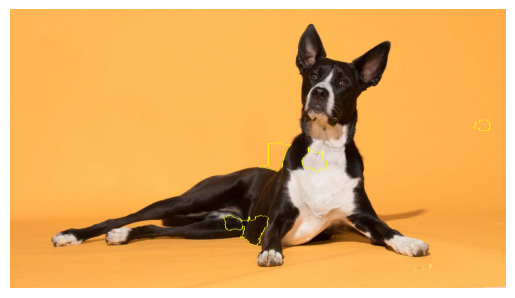

In [22]:
!mkdir datasets
!wget -p https://raw.githubusercontent.com/sprince0031/CS4445-AI-Practice/refs/heads/main/datasets/dog.jpg -O datasets/dog.jpg

# ================================
# Pytest Tests for Challenge #7: LIME Explainability
# ================================

import pytest
import numpy as np
import torch.nn as nn

def run_tests_and_accumulate_score():
    total_code_points = 6  # Tasks 1-4: 2 + 1 + 1 + 2 = 6 points
    score = 0

    # Prepare dummy setup for testing:
    # Create a dummy image (224 x 224 x 3) as a numpy array.
    dummy_image = Image.open("datasets/dog.jpg")
    dummy_image = np.array(dummy_image)

    # Dummy model for LIME explanation tests (for Task 1, 2, 3)
    class DummyModel(nn.Module):
        def __init__(self):
            super(DummyModel, self).__init__()
            self.flatten = nn.Flatten()
            self.fc = nn.Linear(224*224*3, 2)  # Assume 2 classes for simplicity.
        def forward(self, x):
            x = self.flatten(x)
            return torch.softmax(self.fc(x), dim=1)

    dummy_model = DummyModel()

    # ------------------------------
    # Task 1: get_lime_explanation (2 points)
    # ------------------------------
    try:
        explanation = get_lime_explanation(dummy_model, dummy_image, top_labels=2, num_samples=100)
        assert explanation is not None, "get_lime_explanation() returned None."
        # Check for at least one expected method (as_list or get_image_and_mask).
        has_method = hasattr(explanation, "as_list") or hasattr(explanation, "get_image_and_mask")
        assert has_method, "Explanation object lacks expected methods."
        score += 2
        print("Task 1 (get_lime_explanation): Passed (2 points)")
    except AssertionError as e:
        print("Task 1 (get_lime_explanation): Failed -", e)

    # ------------------------------
    # Task 2: display_lime_explanation (1 point)
    # ------------------------------
    try:
        expl_img, mask = display_lime_explanation(explanation, dummy_image, positive_only=True, num_features=5)
        assert expl_img is not None, "display_lime_explanation() returned None for explanation image."
        assert mask is not None, "display_lime_explanation() returned None for mask."
        assert isinstance(expl_img, np.ndarray), "Explanation image should be a numpy array."
        assert isinstance(mask, np.ndarray), "Mask should be a numpy array."
        score += 1
        print("Task 2 (display_lime_explanation): Passed (1 point)")
    except AssertionError as e:
        print("Task 2 (display_lime_explanation): Failed -", e)

    # ------------------------------
    # Task 3: extract_feature_importance (1 point)
    # ------------------------------
    try:
        feature_list = extract_feature_importance(explanation)
        assert isinstance(feature_list, list), "extract_feature_importance() should return a list."
        if feature_list:
            first_item = feature_list[0]
            assert isinstance(first_item, tuple) and len(first_item) == 2, "Each item should be a tuple (feature, importance)."
        score += 1
        print("Task 3 (extract_feature_importance): Passed (1 point)")
    except AssertionError as e:
        print("Task 3 (extract_feature_importance): Failed -", e)

    # ------------------------------
    # Task 4: Pretrained ResNet LIME Explanations (2 points)
    # ------------------------------
    try:
        explanations = get_resnet_lime_explanations(dummy_image)
        assert isinstance(explanations, dict), "get_resnet_lime_explanations() should return a dictionary."
        # Expect 5 keys corresponding to top 5 classes.
        assert len(explanations) == 5, "Expected explanations for top 5 classes."
        print('top 5 label predictions:')
        for i, (label, (expl_img, mask)) in enumerate(explanations.items()):
            assert isinstance(expl_img, np.ndarray), "Explanation image should be a numpy array."
            assert isinstance(mask, np.ndarray), "Mask should be a numpy array."
            print(f'{i+1}. {label}')
            # plt.subplot(1, 5, i+1)
        expl_img, mask = next(iter(explanations.values()))
        visualiseExplanation(expl_img, mask)
        score += 2
        print("Task 4 (ResNet LIME Explanations): Passed (2 points)")
    except AssertionError as e:
        print("Task 4 (ResNet LIME Explanations): Failed -", e)

    print(f"Total Code Score: {score} / {total_code_points}")

    # Reflection questions are graded manually.
    print("Reflection Questions: 3 points (graded manually)")

# Run the autograder.
run_tests_and_accumulate_score()